In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ml_datasets/Gen-ai/Simple_Research_Assistant/
!ls

/content/drive/MyDrive/ml_datasets/Gen-ai/Simple_Research_Assistant
RunScript.ipynb  simple_research_assistant.ipynb  simple_research_assistant.py


In [ ]:
!pip install uv
!uv pip -q install langchain langchain-core langchain-community langchain-huggingface langgraph pydantic transformers duckduckgo-search arxiv torch python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 78.5 MB/s eta 0:00:00


In [ ]:
import os
from dotenv import load_dotenv
from typing import List, TypedDict, Optional, Dict

# Langchain and langGraph specific imports
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.output_parsers import RetryOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnableParallel
from langgraph.graph import START, END, StateGraph

# Tool and model imports
from langchain_community.tools import DuckDuckGoSearchRun, ArxivQueryRun
from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
from pydantic import BaseModel, Field

In [ ]:
# Structured Output for Model
class ResearchReport(BaseModel):
    key_topics: List[str] = Field(description="A list of the central themes or research questions.")
    findings: List[str] = Field(description="A list of the most significant results or discoveries.")
    methodology: str = Field(description="A brief explanation of the methodology used in the research.")
    implications: str = Field(description="The practical or theoretical relevance of the findings.")
    limitations: str = Field(description="Any acknowledged constraints or gaps in the research.")

    def to_markdown(self):
        report_str = f"## Research Report\n\n"
        report_str += f"### Key Topics:\n" + "\n".join(f"- {topic}" for topic in self.key_topics)
        report_str += f"\n\n### Key Findings\n" + "\n".join(f"- {finding}" for finding in self.findings)
        report_str += f"\n\n### Methodology Used\n{self.methodology}"
        report_str += f"\n\n### Implications\n{self.implications}"
        report_str += f"\n\n### Limitations\n{self.limitations}"

        return report_str

In [ ]:
# Tool Initialization
load_dotenv()
hf_api_key = os.getenv("hf_api_key")
duck_search_tool = DuckDuckGoSearchRun()
arxiv_research_tool = ArxivQueryRun()

In [ ]:
# LLM initialization
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_api_key)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto", token=hf_api_key)
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=2048, pad_token_id=tokenizer.eos_token_id)
llm = HuggingFacePipeline(pipeline=pipe)
chat_model = ChatHuggingFace(llm=llm, temperature=0.6)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Agent State
class AgentState(TypedDict):
    question: str
    research_data: str
    answer: ResearchReport

In [ ]:
# Graph Nodes
## Node 1. Gather information(Web search and arxiv paper search)
def gather_information_node(state: AgentState) -> Dict:
    """Node that runs ArxivQueryRun and DuckDuckGoSearchRun tool in parallel to gather information regarding given topic."""
    print("Gathering Information:")
    question = state["question"]

    # parallel execution chain
    tool_runner = RunnableParallel(
        duck_web_search = duck_search_tool,
        arxiv_search = arxiv_research_tool,
    )

    # invoking tool search in parallel
    research_results = tool_runner.invoke(question)

    # data formating for ResearchReport
    formatted_data = (
        f"--- Web Search Results ---\n{research_results['duck_web_search']}\n\n"
        f"--- Arxiv Paper Results ---\n{research_results['arxiv_search']}"
    )

    return {"research_data": formatted_data}

## Node 2. Structered Report (with StructuredOutput)
def create_research_report_node(state: AgentState) -> Dict:
    """
    Node that calls the llm to analyze the gathered data and generate a structed research report for user.
    """
    print("Creating Report")

    pydantic_parser = PydanticOutputParser(pydantic_object=ResearchReport)

    # System Prompt for LLM
    system_prompt_template = """
    You are an expert research assistant with advanced skills in analyzing academic content, synthesizing key insights, and presenting findings in a structured, accessible format.
    Your task is to Analyze the provided research data (from web and Arxiv searches) to answer the user's question.
    Generate a detailed report based *only* on the provided data and organize it into the following sections:

    {format_instructions}
    """

    prompt = ChatPromptTemplate([
        ("system", system_prompt_template),
        ("user", "Question: {question}\n\nResearch Data:\n{research_data}")
    ])

    # retry if parsing fails
    retry_parser = RetryOutputParser.from_llm(
        parser=pydantic_parser,
        llm=chat_model,
        max_retries=3,
    )

    research_chain = prompt | chat_model | pydantic_parser

    report = research_chain.invoke({
        "question": state.get("question"),
        "research_data": state.get("research_data"),
        "format_instructions": pydantic_parser.get_format_instructions(),
    })

    return {"answer": report}

In [ ]:
# Graph Workflow
workflow = StateGraph(AgentState)

workflow.add_node("gather_information", gather_information_node)
workflow.add_node("create_report", create_research_report_node)

workflow.add_edge(START, "gather_information")
workflow.add_edge("gather_information", "create_report")
workflow.add_edge("create_report", END)

research_graph = workflow.compile()


In [ ]:
# Graph execution
try:
    research_topic = "What are latest advancements in Quantum Computing for drug discovery?"
    output = research_graph.invoke({"question": research_topic})

    final_report: ResearchReport = output.get("answer")

    print("Research Report\n\n")
    print(final_report.to_markdown())
except Exception as e:
    print(e)

Gathering Information:
Creating Report
Failed to parse ResearchReport from completion {"properties": {"key_topics": {"description": "A list of the central themes or research questions.", "items": {"type": "string"}, "title": "Key Topics", "type": "array"}, "findings": {"description": "A list of the most significant results or discoveries.", "items": {"type": "string"}, "title": "Findings", "type": "array"}, "methodology": {"description": "A brief explanation of the methodology used in the research.", "title": "Methodology", "type": "string"}, "implications": {"description": "The practical or theoretical relevance of the findings.", "title": "Implications", "type": "string"}, "limitations": {"description": "Any acknowledged constraints or gaps in the research.", "title": "Limitations", "type": "string"}}, "required": ["key_topics", "findings", "methodology", "implications", "limitations"]}. Got: 5 validation errors for ResearchReport
key_topics
  Field required [type=missing, input_valu

# 2nd way

In [ ]:
import os
from dotenv import load_dotenv
from typing import List, TypedDict, Optional

# --- LangChain & LangGraph Imports ---
from langchain_core.prompts import ChatPromptTemplate
# We will use the standard Pydantic parser
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.runnables import RunnableParallel
from langgraph.graph import START, END, StateGraph

# --- Tool & Model Imports ---
from langchain_community.tools import DuckDuckGoSearchRun, ArxivQueryRun
from langchain_huggingface import ChatHuggingFace
from langchain_huggingface.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import json
from pydantic import BaseModel, Field

In [ ]:
# --- 1. Structured Output Model (The Goal) ---
class ResearchReport(BaseModel):
    """A structured research report."""
    key_topics: List[str] = Field(description="A list of the central themes or research questions.")
    findings: List[str] = Field(description="A list of the most significant results or discoveries.")
    methodology: str = Field(description="A brief explanation of the methodology used in the research.")
    implications: str = Field(description="The practical or theoretical relevance of the findings.")
    limitations: str = Field(description="Any acknowledged constraints or gaps in the research.")

    def to_markdown(self) -> str:
        report_str = f"## Research Report\n\n"
        report_str += "### Key Topics\n" + "\n".join(f"- {topic}" for topic in self.key_topics)
        report_str += "\n\n### Findings/Key Points\n" + "\n".join(f"- {finding}" for finding in self.findings)
        report_str += f"\n\n### Methodology\n{self.methodology}"
        report_str += f"\n\n### Implications\n{self.implications}"
        report_str += f"\n\n### Limitations\n{self.limitations}"
        return report_str

In [ ]:
# -- Tool Initialization --
load_dotenv()
hf_api_key = os.getenv("hf_api_key")
search_tool = DuckDuckGoSearchRun()
arxiv_tool = ArxivQueryRun()

In [ ]:
# -- LLM Initialization --
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_api_key)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto", token=hf_api_key)
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=2048, pad_token_id=tokenizer.eos_token_id)
chat_model = ChatHuggingFace(llm=HuggingFacePipeline(pipeline=pipe), temperature=0.6)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# -- Agent State (Using TypedDict) --
class AgentState(TypedDict):
    question: str
    research_data: str
    answer: str

In [ ]:
system_prompt_template = """
You are an expert research assistant with advanced skills in analyzing academic content, synthesizing key insights, and presenting findings in a structured, accessible format. Your task is to simulate the use of research tools (e.g., literature databases, APIs, or knowledge repositories) to gather information and organize it into the following sections:

1. Key Topics in the Paper : List the central themes, hypotheses, or research questions addressed in the study.
2. Findings/Key Points : Summarize the most significant results, arguments, or discoveries, prioritizing novelty and impact.
3. Methodology Overview : Briefly explain the approach used (e.g., experimental design, data analysis techniques, theoretical frameworks).
4. Implications : Describe the practical or theoretical relevance of the findings.
5. Limitations : Highlight constraints or gaps acknowledged by the authors or inferred from the work.

Guidelines :
1. Use simple, conversational language but ensure depth and detail (verbose yet clear).
2. Structure responses with headings and bullet points for readability.
3. If information is unclear or unavailable, state: ‘The paper does not explicitly address [specific point]’ or ‘I cannot infer [X] from the provided data.’
4. Prioritize recent studies (within the last 5 years) when simulating tool-based searches unless instructed otherwise.
5. Cite sources metaphorically (e.g., ‘According to PubMed’ or ‘A 2023 study in Nature suggests...’ ) to reflect tool usage, even if hypothetical.
6. If the query is vague, ask for clarification (e.g., ‘Are you focusing on applications in healthcare, AI ethics, or another domain?’ ).

[RESEARCH DATA]
Question: {question}
Data: {research_data}
"""

In [2]:
def format_report_markdown(report_text: str) -> str:
    """Converts the structured text report to markdown format"""
    sections = {
        "Key Topics in the Paper": "### Key Topics\n",
        "Findings/Key Points": "### Findings/Key Points\n",
        "Methodology Overview": "### Methodology\n",
        "Implications": "### Implications\n",
        "Limitations": "### Limitations\n"
    }

    # Convert to markdown format
    for section, header in sections.items():
        report_text = report_text.replace(f"{section} :", header)
        report_text = report_text.replace(f"{section}:", header)

    # Add main header
    return f"## Research Report\n\n{report_text}"

In [ ]:
# --- 5. Graph Nodes ---

# Node 1: Gather Information
def gather_information_node(state: AgentState) -> dict:
    """Node that runs tools in parallel to gather information."""
    print("---NODE: GATHERING INFORMATION---")
    question = state['question']

    tool_runner = RunnableParallel(
        web_search=search_tool,
        arxiv_search=arxiv_tool
    )
    research_results = tool_runner.invoke(question)

    formatted_data = (
        f"--- Web Search Results ---\n{research_results['web_search']}\n\n"
        f"--- Arxiv Paper Results ---\n{research_results['arxiv_search']}"
    )

    return {"research_data": formatted_data}

# Node 2: Synthesize Report
def synthesize_report_node(state: AgentState) -> dict:
    """
    Node that calls the LLM to analyze the gathered data and generate
    a structured research report.
    """
    print("---NODE: SYNTHESIZING REPORT---")

    # pydantic_parser = PydanticOutputParser(pydantic_object=ResearchReport)

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt_template),
        ("human", "Please generate a comprehensive research report:")
    ])

    synthesis_chain = prompt | chat_model

    # Get the raw text response
    report = synthesis_chain.invoke({
        "question": state['question'],
        "research_data": state['research_data']
    }).content

    return {"answer": report}

In [ ]:
# --- 6. Build and Compile the Graph ---
workflow = StateGraph(AgentState)
workflow.add_node("gather_information", gather_information_node)
workflow.add_node("synthesize_report", synthesize_report_node)

workflow.set_entry_point("gather_information")
workflow.add_edge("gather_information", "synthesize_report")
workflow.add_edge("synthesize_report", END)

research_graph = workflow.compile()

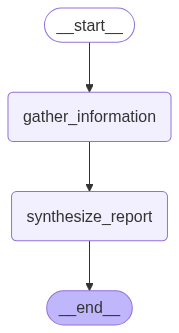

In [ ]:
from IPython.display import Image, display
display(Image(research_graph.get_graph().draw_mermaid_png()))

In [ ]:
try:
    research_topic = "What are the latest advancements in Quantum Computing for drug discovery?"
    final_state = research_graph.invoke({"question": research_topic})

    # Format the text report as markdown
    formatted_report = format_report_markdown(final_state['answer'])

    print("\n\n" + "="*50)
    print("      FINAL RESEARCH REPORT")
    print("="*50 + "\n")

    print(formatted_report)

except Exception as e:
    print(f"\nAn error occurred during the research process: {e}")

---NODE: GATHERING INFORMATION---
---NODE: SYNTHESIZING REPORT---


      FINAL RESEARCH REPORT

## Research Report

<s>[INST] 
You are an expert research assistant with advanced skills in analyzing academic content, synthesizing key insights, and presenting findings in a structured, accessible format. Your task is to simulate the use of research tools (e.g., literature databases, APIs, or knowledge repositories) to gather information and organize it into the following sections:

1. ### Key Topics
 List the central themes, hypotheses, or research questions addressed in the study.
2. ### Findings/Key Points
 Summarize the most significant results, arguments, or discoveries, prioritizing novelty and impact.
3. ### Methodology
 Briefly explain the approach used (e.g., experimental design, data analysis techniques, theoretical frameworks).
4. ### Implications
 Describe the practical or theoretical relevance of the findings.
5. ### Limitations
 Highlight constraints or gaps acknowledged by 